## 数据处理

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

`data/names`目录中包含18个文本文件, 这些文件名为`[Language].txt`。

In [2]:
# 定义findFiles函数，查找符合通配符要求的文件
def findFiles(path): 
    return glob.glob(path)
print(findFiles('data\\names\\*.txt'))

['data\\names\\Arabic.txt', 'data\\names\\Chinese.txt', 'data\\names\\Czech.txt', 'data\\names\\Dutch.txt', 'data\\names\\English.txt', 'data\\names\\French.txt', 'data\\names\\German.txt', 'data\\names\\Greek.txt', 'data\\names\\Irish.txt', 'data\\names\\Italian.txt', 'data\\names\\Japanese.txt', 'data\\names\\Korean.txt', 'data\\names\\Polish.txt', 'data\\names\\Portuguese.txt', 'data\\names\\Russian.txt', 'data\\names\\Scottish.txt', 'data\\names\\Spanish.txt', 'data\\names\\Vietnamese.txt']


In [3]:
import unicodedata
import string
# 获得所有的字母/符号及其长度
# "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'and c in all_letters)

In [8]:
print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Bélanger'))
print(len(all_letters))

Slusarski
Belanger
57


In [4]:
# 定义readLines函数，读取文件，并将文件每一行内容的编码转换为ASCII。
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [5]:
# 定义category_lines字典和all_categories列表
# category_lines：key为语言的类别，value为名称的列表
# all_categories：所有语言的种类
category_lines = {}
all_categories = []
for filename in findFiles('data\\names\\*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print(n_categories)
# 将语言选定为French，内容为前5行的数据进行打印显示。
print(category_lines['French'][:5])

18
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


## 将名称转换为向量

因为字符无法进行数学运算，所以需要将名称转变为向量。
为了表示单个字母，我们使用大小为`1*n_letters`的one-hot向量，因为将离散型特征使用one-hot编码，会让特征之间的距离计算更加合理。

one-hot向量用0填充，但当前字母的索引处的数字为1，例如`"b" = <0 1 0 0 0 ...>`。

为了成为一个词，我们将它们连接成一个 2D 矩阵`<line_length*1*n_letters>`，额外的1维度是因为PyTorch假定一切都是分批次的——我们这里只使用大小为1的批处理。

In [ ]:
import torch
# 定义letterToIndex函数，从all_letters列表中查找字母索引。, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)
# 定义letterToTensor函数，将字母转换成维度是<1 x n_letters>的one-hot向量。
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor
# 定义lineToTensor函数，将一行转化为<line_length x 1 x n_letters>的one-hot向量。
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
print(letterToTensor('A'))
print(lineToTensor('Alex').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([4, 1, 57])


## 创建网络

In [7]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9442, -2.8405, -2.9060, -2.8774, -2.8833, -2.8494, -2.8494, -2.8875,
         -2.8290, -2.9087, -2.8327, -2.9491, -2.9838, -2.9411, -2.9089, -2.9818,
         -2.8510, -2.8258]], grad_fn=<LogSoftmaxBackward0>)


## 网络训练

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [12]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Aalst
category = Vietnamese / line = Hoang
category = Italian / line = Battaglia
category = Japanese / line = Sen
category = French / line = Granger
category = Polish / line = Adamczak
category = Irish / line = Cormac
category = Vietnamese / line = Vo
category = Dutch / line = Middelburg
category = Czech / line = Giersig


In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.005 
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [15]:
import math
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% 2.8172 Moulin / Scottish ✗ (French)
10000 10% 2.3638 Sumner / German ✗ (English)
15000 15% 2.7892 Russell / English ✗ (Scottish)
20000 20% 5.2690 Jones / Dutch ✗ (Scottish)
25000 25% 0.9957 Hadad / Arabic ✓
30000 30% 1.5829 Rahal / Vietnamese ✗ (Arabic)
35000 35% 1.6854 Fakhoury / Japanese ✗ (Arabic)
40000 40% 1.5127 Pozzi / Polish ✗ (Italian)
45000 45% 1.2803 Zou / Korean ✗ (Chinese)
50000 50% 0.1508 Gorski / Polish ✓
55000 55% 2.3980 Geroux / Arabic ✗ (French)
60000 60% 0.5031 Zhai / Chinese ✓
65000 65% 1.0178 Khouri / Japanese ✗ (Arabic)
70000 70% 1.4083 Mendez / Spanish ✓
75000 75% 0.6098 Dao / Vietnamese ✓
80000 80% 2.0726 Renaud / Dutch ✗ (French)
85000 85% 1.4706 Alves / Spanish ✓
90000 90% 1.0130 Lobo / Portuguese ✓
95000 95% 0.8764 O'Byrne / Irish ✓
100000 100% 0.4602 Kui / Chinese ✓


## 模型评估

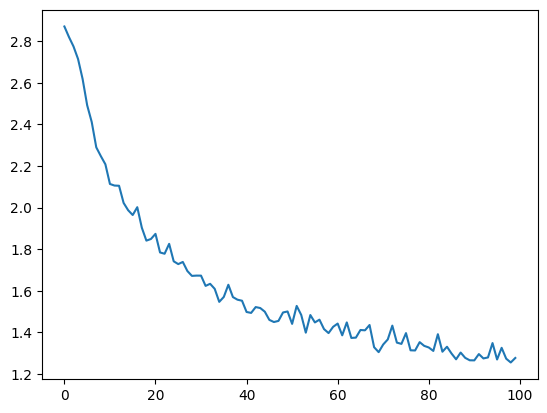

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

In [17]:
# 在混淆矩阵中记录正确预测
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 模型推理
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
# 运行样本，并记录正确的预测
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

C:\Users\82309\AppData\Local\Temp\ipykernel_14452\3055755068.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_categories, rotation=90)
C:\Users\82309\AppData\Local\Temp\ipykernel_14452\3055755068.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(all_categories)


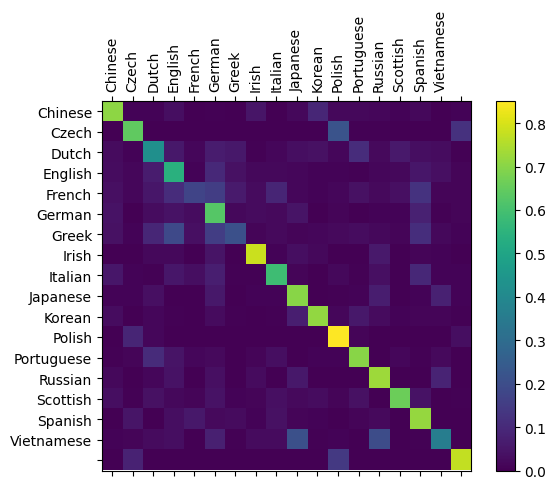

In [18]:
from matplotlib import ticker
import numpy as np
# 绘制图表
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# 设定轴
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticklabels(all_categories)
# 在坐标处添加标签
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [22]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
predict('Qian')


> Qian
(-0.27) Chinese
(-2.01) Vietnamese
(-3.85) Irish
